In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
%matplotlib inline

In [2]:
x = np.arange(-1, 1, 1/100.0)
y = np.arange(-1, 1, 1/100.0)
X, Y = np.meshgrid(x, y)
z1 = mlab.bivariate_normal(X, Y, 0.15, 0.25, -0.5, -0.2)
z2 = mlab.bivariate_normal(X, Y, 0.25, 0.15, 0.8, 0.5)

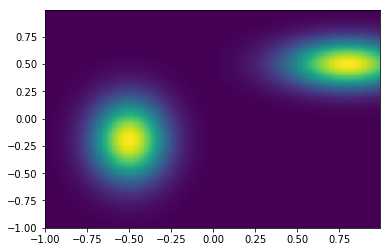

In [3]:
plt.figure()
CS = plt.pcolor(X, Y, z1 + z2)

In [4]:
n_samples = 40000
x = np.random.uniform(-1,1,size = n_samples)
y = np.random.uniform(-1,1,size = n_samples)
X = np.concatenate([[x],[y]]).T

In [5]:
z1 = mlab.bivariate_normal(x, y, 0.25, 0.25, -0.5, -0.2)
z2 = mlab.bivariate_normal(x, y, 0.25, 0.25, 0.8, 0.5)

In [6]:
pi1 = (z1+z2)/3

In [7]:
p = np.zeros(pi1.shape)
h = np.zeros(pi1.shape)

for i in range(len(p)):
    rnd = np.random.uniform()
    if rnd > pi1[i]:
        p[i] = np.random.uniform()
        h[i] = 0
    else:
        p[i] = np.random.beta(a = 0.3, b = 4)
        h[i] = 1
          

In [8]:
def BH(x, alpha = 0.05):
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic]

In [9]:
BH(p)

(1489, 0.001856696534955421)

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [11]:
network = nn.Sequential(
        nn.Linear(1,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,1),
        nn.Sigmoid()
)

soft_compare = nn.Sigmoid()
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)

In [12]:
for item in network.parameters():
    item.data.uniform_(-0.05, 0.05)

In [14]:
loss_hist = []
batch_size = 5000
for iteration in range(20000):
    
    choice = np.random.choice(n_samples, batch_size)
    
    x_input = Variable(torch.from_numpy(X[choice,0:1].astype(np.float32).reshape(batch_size,1)))
    p_input = Variable(torch.from_numpy(p[choice].astype(np.float32).reshape(batch_size,1)))
    
    
    optimizer.zero_grad()
    output = network.forward(x_input) * 0.2
    s = torch.sum(soft_compare((output - p_input) * 1e3)) / batch_size
    s2 = torch.sum(soft_compare((p_input - (1-output)) * 1e3)) / batch_size
    
    gain = s  - 2 * soft_compare((s2 - s*0.05) * 50) 
    
    loss = -gain
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])

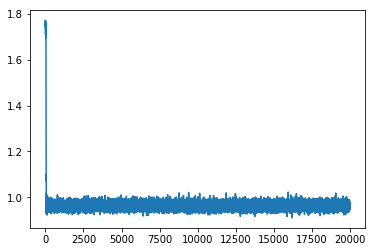

In [15]:
plt.plot(loss_hist)

In [16]:
s

Variable containing:
1.00000e-02 *
  3.5171
[torch.FloatTensor of size 1]

In [17]:
s2/s

Variable containing:
1.00000e-02 *
  3.6644
[torch.FloatTensor of size 1]

In [20]:
x_input = Variable(torch.from_numpy(X[:,0:1].astype(np.float32).reshape(n_samples ,1)))
p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1)))

output = network.forward(x_input) * 0.2
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

In [21]:
np.sum(pred)

1600.0

In [22]:
np.sum(h)

5908.0

In [23]:
np.sum(pred * h) / np.sum(pred)

0.948125

In [24]:
x2 = np.arange(-1, 1, 1/100.0)
y2 = np.arange(-1, 1, 1/100.0)
X2, Y2 = np.meshgrid(x2, y2)

In [27]:
x_in = Variable(torch.from_numpy(np.concatenate([[X2.flatten()]]).T.astype(np.float32)))

In [28]:
out = network(x_in)

In [29]:
z = out.data.numpy().reshape(X2.shape)

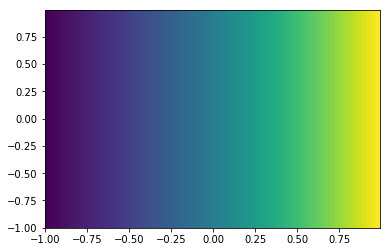

In [30]:
plt.figure()
CS = plt.pcolor(X2, Y2, z)